In [16]:
import sys
sys.path.append('../')
import numpy as np
import importlib
import dataloader as u
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import keras
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Embedding, LSTM, Dense, TimeDistributed, Activation, Dropout, Input
from tensorflow.keras.regularizers import L1L2
import tensorflow.keras.backend as K
importlib.reload(u)

<module 'dataloader' from '..\\dataloader.py'>

In [4]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)

    except RuntimeError as e:
        print(e)

In [5]:
datadict = u.load_covid_timeseries(smoothing=3, cases_cutoff=5)
cases = datadict['cases_calibrated']
deaths = datadict['deaths_calibrated']

In [6]:
demographics = u.load_demographics_data()
demographics.head()

,FIPS,total_pop,60plus,area,median_age,pop_white,pop_black,pop_hispanic,pop_density,p60_plus
0,1001,55036,10523,594.44,37.8,76.9,19.1,2.8,92.584617,0.191202
1,1003,203360,53519,1589.78,42.8,86.3,9.5,4.5,127.917070,0.263174
2,1005,26201,6150,884.88,39.9,47.4,47.6,4.3,29.609665,0.234724
3,1007,22580,4773,622.58,39.9,76.7,22.3,2.4,36.268431,0.211382
4,1009,57667,13600,644.78,40.8,95.5,1.5,9.1,89.436707,0.235837


In [7]:
pop = np.expand_dims(demographics['total_pop'].values, axis=1)
cases_norm = cases / pop * 10000
deaths_norm = deaths / pop * 10000

In [8]:
def transform(x):
    x0 = np.expand_dims(x[:, 0], axis=1)
    t = np.diff(x)
    t0 = np.expand_dims(t[:, 0], axis=1)
    t = np.diff(t)
    return t, t0, x0

In [9]:
def untransform(t, t0, x0, a=1):
    x = np.hstack([t0, t])
    x = np.cumsum(x, axis=a)
    x = np.hstack([x0, x])
    x = np.cumsum(x, axis=a)
    return x

In [10]:
cases2, ct0, cx0 = transform(cases_norm)
deaths2, dt0, dx0 = transform(deaths_norm)

(3143, 99)


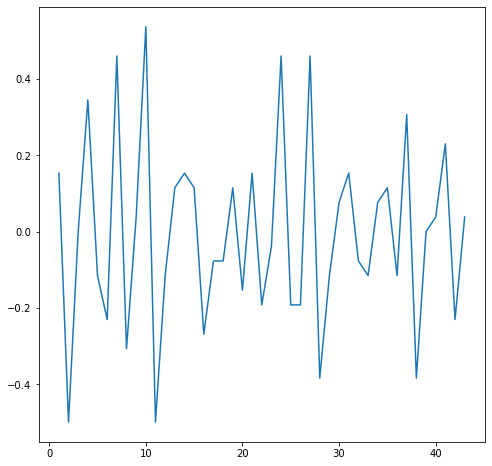

In [11]:
d = cases2
x1 = np.linspace(1, d.shape[1], d.shape[1])
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
plt.plot(x1, d[206])
print(d.shape)
plt.show()

In [69]:
X_train = []
y_train = []
X_test = []
y_test = []
lag = 8
k = 8
validation_steps = 4
for j in range(deaths2.shape[0]):
    d = deaths2[j]
    c = cases2[j]
    if np.all(np.isnan(d)) or np.all(np.isnan(c)):
        continue
    s = np.argmax(np.isnan(d))
    for i in range(s):
        if np.any(np.isnan(d[i:i+lag+k])) or np.any(np.isnan(c[i:i+lag+k])):
            break
        x = np.vstack([c[i:i+lag], d[i:i+lag], np.full((lag,), i)]).T
        if i < s - validation_steps - lag - k:
            X_train.append(x)
            y_train.append(np.vstack([c[i+lag:i+lag+k], d[i+lag:i+lag+k]]).T)
        else:
            X_test.append(x)
            y_test.append(np.vstack([c[i+lag:i+lag+k], d[i+lag:i+lag+k]]).T)
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

In [70]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(21360, 8, 3) (21360, 8, 2) (8851, 8, 3) (8851, 8, 2)


In [71]:
def LSTM_model():
    model = Sequential()
    model.add(LSTM(64, input_shape=X_train.shape[1:], activation='relu', return_sequences=True, recurrent_regularizer=L1L2(0,1e-2), kernel_regularizer=L1L2(0, 0.1)))
    model.add(TimeDistributed(Dense(2, kernel_regularizer=L1L2(0.1, 0.1))))
    return model

In [72]:
def quantile_head(inputs):
    x = TimeDistributed(Dense(2, kernel_regularizer=L1L2(0.1, 0.1)))(inputs)
    return x

In [73]:
def LSTM_model2():
    inputs = Input(shape=X_train.shape[1:])
    x = LSTM(64, return_sequences=True, activation='relu', recurrent_regularizer=L1L2(0,1e-2), kernel_regularizer=L1L2(0, 0.1))(inputs)
    x = Dropout(0.1)(x)
    
    qheads = []
    for i in range(9):
        qheads.append(quantile_head(x))
        
    model = Model(inputs=inputs, outputs=qheads)
    return model

In [97]:
def pinball_loss(q, pred, true):
    e = true - pred
    return K.mean(K.maximum(q*e, (q-1)*e))

In [135]:
from tensorflow.keras.optimizers import Adam

with tf.device('/GPU:0'):
    model = LSTM_model2()

losses = [lambda pred, true, q=q: pinball_loss(q, pred, true) for q in np.arange(0.1, 1, 0.1)]
opt = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, decay=0.01)
model.compile(loss=losses, optimizer=opt)
model.summary()

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 8, 3)]       0                                            
__________________________________________________________________________________________________
lstm_11 (LSTM)                  (None, 8, 64)        17408       input_12[0][0]                   
__________________________________________________________________________________________________
dropout_11 (Dropout)            (None, 8, 64)        0           lstm_11[0][0]                    
__________________________________________________________________________________________________
time_distributed_85 (TimeDistri (None, 8, 2)         130         dropout_11[0][0]                 
____________________________________________________________________________________________

In [146]:
with tf.device('/GPU:0'):
    model.fit(X_train, y_train, epochs=25, batch_size=72, validation_data=(X_test, y_test), verbose=2, shuffle=True)

Epoch 1/25
297/297 - 5s - loss: 16.7841 - time_distributed_85_loss: 0.1442 - time_distributed_86_loss: 0.1759 - time_distributed_87_loss: 0.1788 - time_distributed_88_loss: 0.1834 - time_distributed_89_loss: 0.1844 - time_distributed_90_loss: 0.1959 - time_distributed_91_loss: 0.1818 - time_distributed_92_loss: 0.1593 - time_distributed_93_loss: 0.1526 - val_loss: 17.0075 - val_time_distributed_85_loss: 0.1634 - val_time_distributed_86_loss: 0.2015 - val_time_distributed_87_loss: 0.2076 - val_time_distributed_88_loss: 0.2085 - val_time_distributed_89_loss: 0.2075 - val_time_distributed_90_loss: 0.2431 - val_time_distributed_91_loss: 0.2143 - val_time_distributed_92_loss: 0.1848 - val_time_distributed_93_loss: 0.1754
Epoch 2/25
297/297 - 5s - loss: 16.7290 - time_distributed_85_loss: 0.1441 - time_distributed_86_loss: 0.1756 - time_distributed_87_loss: 0.1785 - time_distributed_88_loss: 0.1830 - time_distributed_89_loss: 0.1840 - time_distributed_90_loss: 0.1952 - time_distributed_91_lo

Epoch 13/25
297/297 - 5s - loss: 16.2384 - time_distributed_85_loss: 0.1429 - time_distributed_86_loss: 0.1725 - time_distributed_87_loss: 0.1760 - time_distributed_88_loss: 0.1805 - time_distributed_89_loss: 0.1820 - time_distributed_90_loss: 0.1898 - time_distributed_91_loss: 0.1777 - time_distributed_92_loss: 0.1576 - time_distributed_93_loss: 0.1498 - val_loss: 16.4554 - val_time_distributed_85_loss: 0.1622 - val_time_distributed_86_loss: 0.1976 - val_time_distributed_87_loss: 0.2020 - val_time_distributed_88_loss: 0.2042 - val_time_distributed_89_loss: 0.2040 - val_time_distributed_90_loss: 0.2305 - val_time_distributed_91_loss: 0.2074 - val_time_distributed_92_loss: 0.1826 - val_time_distributed_93_loss: 0.1730
Epoch 14/25
297/297 - 5s - loss: 16.2022 - time_distributed_85_loss: 0.1429 - time_distributed_86_loss: 0.1724 - time_distributed_87_loss: 0.1758 - time_distributed_88_loss: 0.1804 - time_distributed_89_loss: 0.1818 - time_distributed_90_loss: 0.1896 - time_distributed_91_

Epoch 25/25
297/297 - 5s - loss: 15.8558 - time_distributed_85_loss: 0.1423 - time_distributed_86_loss: 0.1705 - time_distributed_87_loss: 0.1744 - time_distributed_88_loss: 0.1788 - time_distributed_89_loss: 0.1807 - time_distributed_90_loss: 0.1863 - time_distributed_91_loss: 0.1752 - time_distributed_92_loss: 0.1564 - time_distributed_93_loss: 0.1482 - val_loss: 16.0674 - val_time_distributed_85_loss: 0.1614 - val_time_distributed_86_loss: 0.1952 - val_time_distributed_87_loss: 0.1987 - val_time_distributed_88_loss: 0.2017 - val_time_distributed_89_loss: 0.2019 - val_time_distributed_90_loss: 0.2230 - val_time_distributed_91_loss: 0.2033 - val_time_distributed_92_loss: 0.1812 - val_time_distributed_93_loss: 0.1713


In [124]:
model.save('lstm_quantile_15.h5')

In [96]:
model = load_model('lstm_2.h5')
model.summary()

ValueError: Unknown loss function:<lambda>

In [137]:
n_counties = deaths2.shape[0]
n_features = 3

In [147]:
X = np.zeros((n_counties, lag, n_features))
t = lag + validation_steps
for county in range(n_counties):
    f = deaths2[county]
    if np.all(np.isnan(f)):
        continue

    # s is the end of the series
    if np.all(~np.isnan(f)):
        s = f.shape[0]
    else: 
        s = np.argmax(np.isnan(f))

    i = s - t 
    if i < 0:
        continue

    x = np.vstack([feature[county, i:i + lag] for feature 
            in [cases2, deaths2]])
    x = np.vstack([x, np.full((lag, ), i)])
    x = x.T

    X[county, :] = x

y_pred = model.predict(X)

In [148]:
pred = np.array(y_pred)

In [136]:
cases_predictions = {}
deaths_predictions = {}
count = 0
for county in range(deaths2.shape[0]):
    count += 1
    if count % 50 == 0:
        print(count)
    d = deaths2[county]
    c = cases2[county]
    if np.all(np.isnan(d)) or np.all(np.isnan(c)):
        continue
    s = np.argmax(np.isnan(d))
    if s < lag + validation_steps:
        continue
    i = s - lag - validation_steps
    X = np.expand_dims(np.vstack([c[i:i+lag], d[i:i+lag], np.full((lag, ), i)]).T, axis=0)
    predictions1 = model.predict(X)
    X = np.expand_dims(np.hstack([predictions1[0], np.full((lag, 1), i)]), axis=0)
    predictions2 = model.predict(X)
    predictions = np.vstack([predictions1[0], predictions2[0]])
    cases_predictions[county] = predictions.T[0]
    deaths_predictions[county] = predictions.T[1]

50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450
1500
1550
1600
1650
1700
1750
1800
1850
1900
1950
2000
2050
2100
2150
2200
2250
2300
2350
2400
2450
2500
2550
2600
2650
2700
2750
2800
2850
2900
2950
3000
3050
3100


In [120]:
print(cases_predictions.keys())

dict_keys([0, 1, 3, 4, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 18, 19, 21, 23, 24, 25, 27, 29, 31, 32, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 69, 74, 77, 78, 79, 96, 97, 98, 103, 104, 105, 106, 107, 108, 109, 110, 112, 114, 120, 122, 123, 126, 128, 129, 133, 136, 137, 138, 140, 145, 146, 148, 150, 153, 156, 166, 167, 168, 170, 171, 172, 173, 175, 176, 177, 179, 180, 181, 182, 183, 186, 189, 192, 194, 195, 197, 198, 199, 200, 201, 204, 205, 206, 209, 211, 212, 213, 214, 215, 216, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 233, 234, 235, 236, 239, 241, 242, 243, 244, 246, 247, 248, 250, 251, 252, 254, 260, 262, 263, 264, 265, 267, 270, 274, 278, 279, 282, 283, 286, 287, 288, 293, 295, 298, 301, 303, 304, 306, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 327, 328, 329, 330, 331, 332, 334, 335, 336, 338, 344, 345, 346, 347, 349, 351, 353, 354,

In [149]:
dp2 = {}
pop = np.expand_dims(demographics['total_pop'].values, axis=1)
for county in range(n_counties):
    d = deaths2[county]
    
    predicted_deaths = pred[4, county, :, 1]
    
    s = np.argmax(np.isnan(d))
    d2 = np.concatenate([d[:(s - validation_steps)], predicted_deaths])
    
    dp2[county] = untransform(d2, dt0[county], dx0[county], 0)
    
    dp2[county] = dp2[county] * pop[county, 0] / 10000

In [150]:
dp3 = {}
pop = np.expand_dims(demographics['total_pop'].values, axis=1)
for county in range(n_counties):
    d = deaths2[county]
    
    predicted_deaths = pred[0, county, :, 1]
    
    s = np.argmax(np.isnan(d))
    d2 = np.concatenate([d[:(s - validation_steps)], predicted_deaths])
    
    dp3[county] = untransform(d2, dt0[county], dx0[county], 0)
    
    dp3[county] = dp3[county] * pop[county, 0] / 10000

In [151]:
dp4 = {}
pop = np.expand_dims(demographics['total_pop'].values, axis=1)
for county in range(n_counties):
    d = deaths2[county]
    
    predicted_deaths = pred[8, county, :, 1]
    
    s = np.argmax(np.isnan(d))
    d2 = np.concatenate([d[:(s - validation_steps)], predicted_deaths])
    
    
    dp4[county] = untransform(d2, dt0[county], dx0[county], 0)
    
    dp4[county] = dp4[county] * pop[county, 0] / 10000

In [152]:
dp4[county]

array([   0.        ,    0.        ,    0.        ,    0.        ,
          1.        ,    1.        ,    1.        ,    1.        ,
          1.        ,    1.        ,    1.        ,    1.        ,
          1.        ,    2.        ,    3.        ,    3.        ,
          4.        ,    4.        ,    4.        ,    4.        ,
          4.        ,    4.        ,    4.        ,    4.        ,
          5.        ,    5.        ,    6.        ,    6.        ,
          6.        ,    6.        ,    6.        ,    6.        ,
          6.        ,    6.        ,    6.        ,    6.        ,
          6.        ,    6.        ,    6.        ,    6.        ,
          6.        ,    6.04151521,    1.81910887,   -8.72638786,
        -26.32533877,  -50.8533251 ,  -82.6517947 , -122.07913856,
       -169.23492786])

In [137]:
cp2 = {}
dp2 = {}
pop = np.expand_dims(demographics['total_pop'].values, axis=1)
for county in cases_predictions:
    d = deaths2[county]
    c = cases2[county]
    s = np.argmax(np.isnan(d))
    d2 = np.concatenate([d[:(s - validation_steps)], deaths_predictions[county]])
    c2 = np.concatenate([c[:(s - validation_steps)], cases_predictions[county]])
    
    cp2[county] = untransform(c2, ct0[county], cx0[county], 0)
    dp2[county] = untransform(d2, dt0[county], dx0[county], 0)
    
    cp2[county] = cp2[county] * pop[county, 0] / 10000
    dp2[county] = dp2[county] * pop[county, 0] / 10000

In [54]:
mse = 0
n = 0
for county in deaths_predictions:
    n += 1
    s = np.argmax(np.isnan(deaths2[county]))
    pred = dp2[county][(s - validation_steps):s]
    real = deaths[county][(s - validation_steps):s]
    mse += np.sum((pred - real)**2)
    break
print(mse / (n*validation_steps))

NameError: name 'deaths_predictions' is not defined

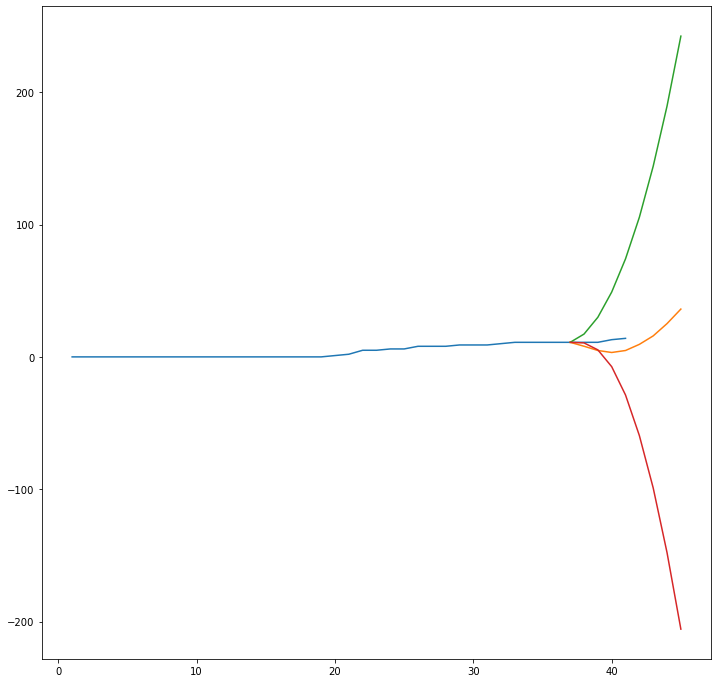

In [156]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)

county = 1859

d1 = deaths
x1 = np.linspace(1, d1.shape[1], d1.shape[1])
plt.plot(x1, d1[county])

s = np.argmax(np.isnan(d1[county])) - 1
d2 = dp2[county]
x2 = np.linspace(1, d2.shape[0], d2.shape[0])
plt.plot(x2[s - validation_steps:], d2[s - validation_steps:])

d2 = dp3[county]
x2 = np.linspace(1, d2.shape[0], d2.shape[0])
plt.plot(x2[s - validation_steps:], d2[s - validation_steps:])

d2 = dp4[county]
x2 = np.linspace(1, d2.shape[0], d2.shape[0])
plt.plot(x2[s - validation_steps:], d2[s - validation_steps:])

plt.show()